<a href="https://colab.research.google.com/github/Flagy/LungModel/blob/master/DataSetCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal.ltisys import TransferFunctionContinuous

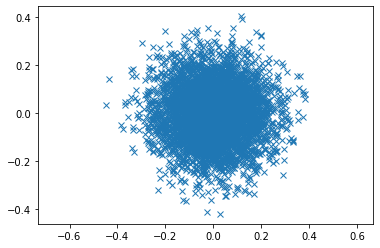

In [ ]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
cov2 = [[2, 0], [0, 2]]  # diagonal covariance
X = np.random.multivariate_normal(mean, cov, 5000).T
x2, y2 = X / 10 + X / np.sqrt(np.square(X).sum(axis=1, keepdims=True))
plt.plot(x2, y2, 'x')
plt.axis('equal')
plt.show()

In [ ]:
def generateData(**kwargs):
    np.random.seed(42)
    e1 = kwargs['E1'] + np.random.normal(loc=0, scale=kwargs['stdE'], size=1000)
    e2 = kwargs['E2'] + np.random.normal(loc=0, scale=kwargs['stdE'], size=1000)
    rc = 0.25
    r1 = kwargs['R1'] + np.random.normal(loc=0, scale=kwargs['stdR'], size=1000)
    r2 = kwargs['R2'] + np.random.normal(loc=0, scale=kwargs['stdR'], size=1000)
    return({'E1':e1, 'E2':e2, 'Eeq':e1*e2/(e1+e2), 'Rc':rc, 'R1':r1, 'R2':r2, 'Req': rc+r1*r2/(r1+r2), 'label':kwargs['label']})

stdE = 5
stdR = 0.5
Fibrosis = generateData(E1=40, E2=40, stdE=stdE, R1=5.5, R2=5.5, stdR=stdR, label='Fibrosis')
Asthma = generateData(E1=20, E2=20, stdE=stdE, R1=9.5, R2=9.5, stdR=stdR, label='Asthma')
Healthy = generateData(E1=20, E2=20, stdE=stdE, R1=5.5, R2=5.5, stdR=stdR, label='Healthy')

In [ ]:
# Create pandas table
import pandas as pd
dfF = pd.DataFrame(Fibrosis)
dfA = pd.DataFrame(Asthma)
dfH = pd.DataFrame(Healthy)
df = pd.concat([dfF,dfA,dfH],ignore_index=True).drop_duplicates().reset_index(drop=True)
df[df.label=='Fibrosis'].head()
df[df.label=='Asthma'].head()
df[df.label=='Healthy'].head()

,E1,E2,Eeq,Rc,R1,R2,Req,label
2000,22.483571,26.996777,12.267172,0.25,5.162411,4.546096,2.667346,Healthy
2001,19.308678,24.623168,10.822237,0.25,5.427741,5.069807,2.871336,Healthy
2002,23.238443,20.298152,10.834505,0.25,5.103790,5.293197,2.848384,Healthy
2003,27.615149,16.765316,10.431993,0.25,5.346019,6.443844,3.171910,Healthy
2004,18.829233,23.491117,10.451703,0.25,4.553193,5.778277,2.796550,Healthy


Text(0.5, 1.0, 'Data distribution')

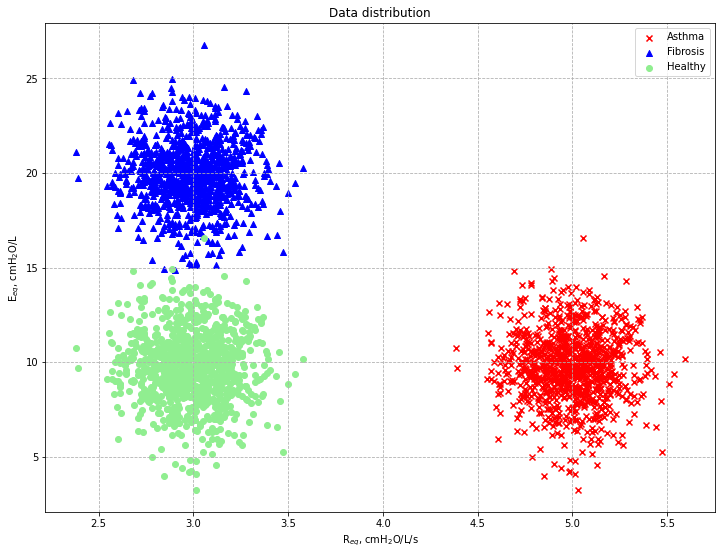

In [ ]:
from matplotlib.colors import ListedColormap
markers = ('x', '^', 'o', 's', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[3])
# plot the decision surface
H = df[df.label=='Healthy']
A = df[df.label=='Asthma']
F = df[df.label=='Fibrosis']
fig = plt.figure(figsize=(12, 9))
plt.scatter(A.Req, A.Eeq, color=colors[0], marker=markers[0], label='Asthma')
plt.scatter(F.Req, F.Eeq, color=colors[1], marker=markers[1], label='Fibrosis')
plt.scatter(H.Req, H.Eeq, color=colors[2], marker=markers[2], label='Healthy')

plt.legend()
plt.grid(linestyle='--')
plt.xlabel(r'R$_{eq}$, cmH$_2$O/L/s')
plt.ylabel(r'E$_{eq}$, cmH$_2$O/L')
plt.title('Data distribution')

In [ ]:
class ParallelModel(TransferFunctionContinuous):
    def __init__(self, **params):
        self.setParams(**params)
    
    def setParams(self, **params):
        self.n_Rc = params['Rc'] # Normally 0.25
        self.n_R1 = params['R1'] # Normally = 5.5
        self.n_R2 = params['R2'] # Normally = 5.5
        self.n_E1 = params['E1'] # Normally 20
        self.n_E2 = params['E2'] # Normally 20
        super().__init__([self.n_R1 + self.n_R2, self.n_E1 + self.n_E2], 
                         [self.n_R1 * self.n_R2 + self.n_Rc * (self.n_R1 + self.n_R2),
                         (self.n_R2 + self.n_Rc) * self.n_E1 + (self.n_R1 + self.n_Rc)*self.n_E2,
                          self.n_E1 * self.n_E2])
        

class BhoratModel(TransferFunctionContinuous):
      def __init__(self, **params):
        self.setParams(**params)
    
    def setParams(self, **params):
      self.n

In [ ]:
def p(t, p0):
    t = t % 4
    if t < 0.6:
        pp = -10*np.sin(np.pi*t/1.2)
    elif t < 0.8:
        pp = -10
    elif t < 1:
        pp = -10*np.sin(np.pi*(t - 0.6)/0.4)
    elif t < 4:
        pp = 0
    else:
        raise ValueError("Something wrong in t")
    return pp + p0

tspan = np.linspace(0, 20, 1000)
PEEP = 0
breathingPressure = np.vectorize(p)(tspan, PEEP)
output = []
for index, row in df.iterrows():
    s = ParallelModel(**dict(row))
    output.append(s.output(breathingPressure, tspan)[1])
df['output_Volume'] = output

In [ ]:
import pickle
!touch Table3.pkl
with open("Table3.pkl", "wb") as f:
  pickle.dump(df, f)
